In [1]:
from clustering_helper import *
from clustering_basic import kmeans_clustering as kc
from clustering_basic import diametrical_clustering as dc
from clustering_grassmannian import grassmannian_clustering_chordal as gcc
from clustering_grassmannian import grassmannian_clustering_geodesic as gcg
from clustering_grassmannian import weighted_grassmann_clustering as wgc
import pickle
import os

from IPython.display import clear_output

In [3]:
def synthdat(pK_comb, method_dict, N_seed, N, noise_scale):
    c_dict = {}
    for p,K in tqdm(pK_comb):
        for seed in tqdm(range(N_seed), leave=False):
            _, data_gr, data_eigvals = generate_data(p,K,N,noise_scale,seed)
            for method, cc in method_dict.items():
                try:
                    if method=="wgc": c_data = cc(data_gr, data_eigvals, K)
                    else:             c_data = cc(data_gr, K)
                    c_dict[(p,K,seed,method)] = c_data
                except Exception as e:
                    print("\n",p,K,method,seed)
                    print("Error: ", e)
    return c_dict

def fix_missing(c_dict, pK_comb, method_dict, N_seed, N, noise_scale):
    all_comb = [(p,K,method,seed) for p,K in pK_comb for method in method_dict.keys() for seed in range(N_seed)]
    missing_comb = []

    for p,K,method,seed in all_comb:
        if (p,K,seed,method) in c_dict: continue
        else: missing_comb.append((p,K,seed,method))
    print(len(missing_comb))

    for p,K,seed,method in tqdm(missing_comb):
        _, data_gr, data_eigvals = generate_data(p,K,N,noise_scale,seed=seed)
        if method == "wgc": c_data = wgc(data_gr, data_eigvals, K)
        else: c_data = method_dict[method](data_gr, K)
        c_dict[(p,K,seed,method)] = c_data

    return c_dict

def get_plot_dict(c_dict):
    # import pickle
    from collections import defaultdict
    plot_dict = defaultdict(list)

    # c_dict_loaded = pickle.load(open("clustering_dict.pkl", "rb"))
    for (p,K,seed,method), c_data in c_dict.items():
        if isinstance(c_data, str): continue
        if method=="wgc": centroids,weights,labels,obj = c_data
        else: centroids,labels,obj = c_data
        
        true_labels = get_true_labels(K,N)
        plot_dict[(p,K,method)] += [calc_NMI(labels, true_labels)]
    return plot_dict

plot_dict_median = lambda plot_dict: {(p,K,method): np.median(NMI_list) for (p,K,method),NMI_list in plot_dict.items()}

pK_comb = [(p, K) for p in [3, 4, 5, 10, 15, 20, 25, 30, 40, 50] for K in range(2, min(9, p+1))]
method_dict = {"kc":kc, "dc":dc, "gcc":gcc, "wgc":wgc}

N_seed = 10
N = 5_000
noise_scale = 1.5

In [163]:
# "10 7 dc  2  - Eror:  too many indices for array: array is 2-dimernsional, but 3 were indexed - RuntimeWarning: invalid value encountered in divide: C = C/np.linalg.norm(C,axis=0) # normalize the cluster centers - Diametrical clustering returned nan. Repeating"
# "15 4 dc  13 - Error:  index 9999 is out of bounds for axis 0 with size 9999"
# "15 7 wgc 3  - Error:  `A` must not be empty. - RuntimeWarning: invalid value encountered in divide: C_weights[k] = C_weights[k]/np.sum(C_weights[k])*p"
# "15 8 wgc 12 - Error:  `k` must be an integer satisfying `0 < k < min(A.shape)`."
# "15 8 wgc 14 - Error:  `A` must not be empty."

# # BAD SEED: 1
# # dc(generate_data(50,7,noise_scale=0.5,seed=1)[1], K)

# p,K,seed = 50,7,20

# # for method in method_dict.keys():
# #     c_dict[(p,K,1,method)] = "Error: bad seed"

# for method in method_dict.keys():
#     _, data_gr, data_eigvals = generate_data(p,K,noise_scale=0.5,seed=seed)
#     if method == "wgc": c_data = wgc(data_gr, data_eigvals, K)
#     else: c_data = method_dict[method](data_gr, K)
#     c_dict[(p,K,seed,method)] = c_data

# bad_seed = 1 # p=50, K=7
# for method in method_dict.keys():
#     all_comb.pop(all_comb.index((50,7,method,bad_seed)))

In [61]:
c_dict = synthdat(pK_comb, method_dict, N_seed, N, noise_scale) # often missing some vals
fix_missing(c_dict, pK_comb, method_dict, N_seed, N, noise_scale);

 24%|██▍       | 14/58 [00:57<04:41,  6.40s/it]c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\Fagprojekt\Github-Fagprojekt\clustering_grassmannian.py:231: RuntimeWarning: invalid value encountered in divide
  C_weights[k] = C_weights[k]/np.sum(C_weights[k])*p



 10 7 wgc 4
Error:  `A` must not be empty.


 48%|████▊     | 28/58 [04:28<09:40, 19.34s/it]c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\Fagprojekt\Github-Fagprojekt\clustering_basic.py:75: RuntimeWarning: invalid value encountered in divide
  C = C/np.linalg.norm(C,axis=0) # normalize the cluster centers


Diametrical clustering returned nan. Repeating

 20 7 dc 2
Error:  too many indices for array: array is 2-dimensional, but 3 were indexed


 59%|█████▊    | 34/58 [06:56<09:24, 23.51s/it]c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\Fagprojekt\Github-Fagprojekt\clustering_basic.py:75: RuntimeWarning: invalid value encountered in divide
  C = C/np.linalg.norm(C,axis=0) # normalize the cluster centers


Diametrical clustering returned nan. Repeating

 25 6 dc 2
Error:  too many indices for array: array is 2-dimensional, but 3 were indexed


 83%|████████▎ | 48/58 [15:55<07:41, 46.12s/it]c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\Fagprojekt\Github-Fagprojekt\clustering_basic.py:75: RuntimeWarning: invalid value encountered in divide
  C = C/np.linalg.norm(C,axis=0) # normalize the cluster centers


Diametrical clustering returned nan. Repeating

 40 6 dc 5
Error:  too many indices for array: array is 2-dimensional, but 3 were indexed


 90%|████████▉ | 52/58 [20:34<06:20, 63.38s/it]c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\Fagprojekt\Github-Fagprojekt\clustering_basic.py:75: RuntimeWarning: invalid value encountered in divide
  C = C/np.linalg.norm(C,axis=0) # normalize the cluster centers


Diametrical clustering returned nan. Repeating

 50 3 dc 4
Error:  too many indices for array: array is 2-dimensional, but 3 were indexed


 95%|█████████▍| 55/58 [24:09<03:30, 70.03s/it]c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\Fagprojekt\Github-Fagprojekt\clustering_basic.py:75: RuntimeWarning: invalid value encountered in divide
  C = C/np.linalg.norm(C,axis=0) # normalize the cluster centers


Diametrical clustering returned nan. Repeating

 50 6 dc 1
Error:  too many indices for array: array is 2-dimensional, but 3 were indexed


100%|██████████| 58/58 [29:33<00:00, 30.57s/it]


In [69]:
i = 0
while True:
    if os.path.exists(f"clustering_results_{i}.pkl"): i+=1; continue
    else: pickle.dump(c_dict, open(f"clustering_results_{i}.pkl", "wb")); break

plot_dict = get_plot_dict(c_dict)
median_dict = plot_dict_median(plot_dict)

In [5]:
i = 0
c_dict = pickle.load(open(f"clustering_results_{i}.pkl", "rb"))

In [6]:
plot_dict = get_plot_dict(c_dict)
median_dict = plot_dict_median(plot_dict)

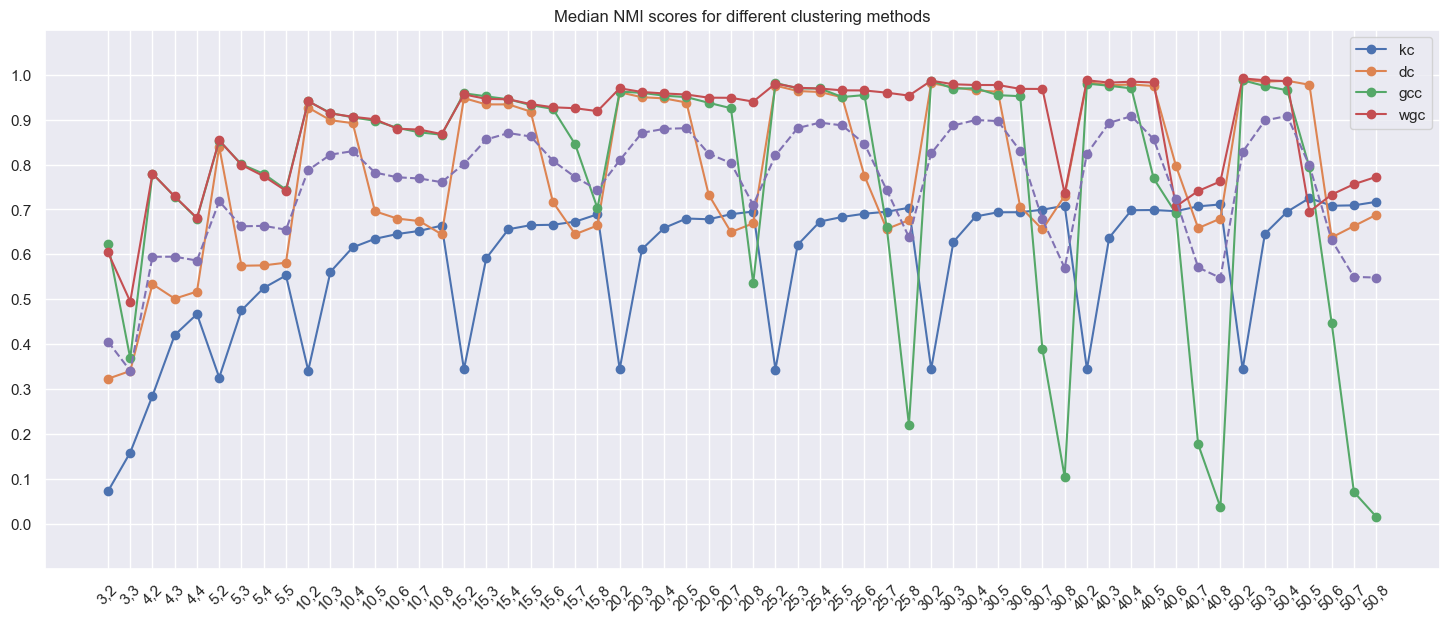

In [8]:
from seaborn import set_theme
set_theme()

plt.figure(figsize=(18,7))
plt.title("Median NMI scores for different clustering methods")
# plt.subplots_adjust(hspace=0.33)
for method in method_dict.keys():
    # plt.subplot(2,2,1+list(method_dict.keys()).index(method))
    plt.plot([median_dict[(p,K,method)] for p,K in pK_comb], linestyle="-", marker="o", label=method)
    plt.legend()
    plt.ylim(-0.1,1.1)
    plt.yticks(np.linspace(0,1,11))
    plt.xticks(range(len(pK_comb)), [f"{p},{K}" for p,K in pK_comb], rotation=45)
# also plot the average of all methods:
plt.plot([np.mean([median_dict[(p,K,method)] for method in method_dict.keys()]) for p,K in pK_comb], linestyle="--", marker="o", label="avg")

plt.show()

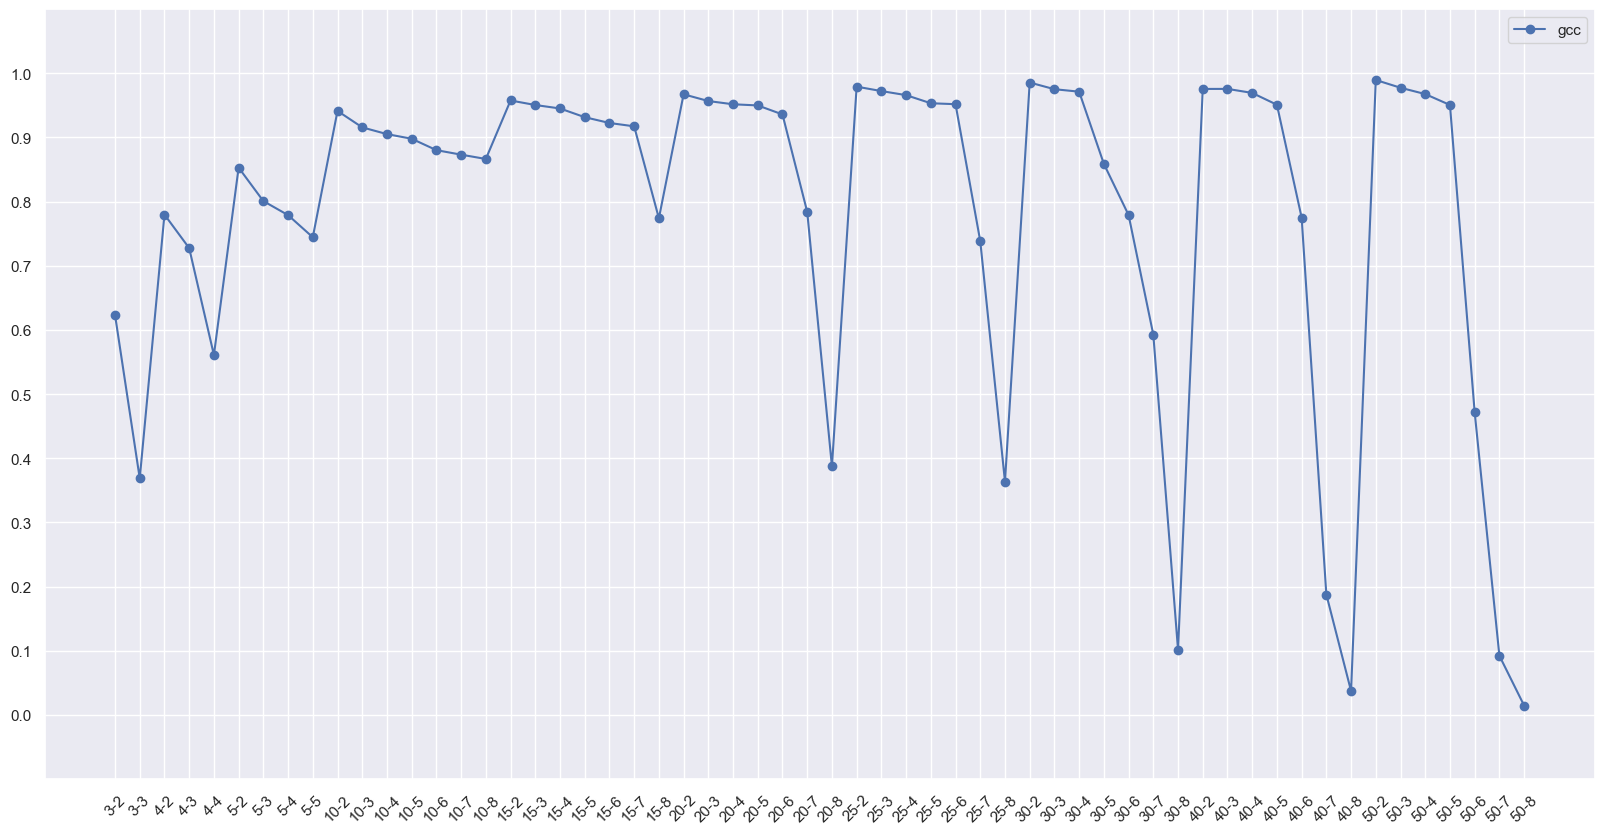

In [7]:
from seaborn import set_theme
set_theme()

mask = [True for p,K in pK_comb]
pK_comb_masked = np.array(pK_comb)[mask]

plt.figure(figsize=(20,10))
plt.plot([plot_dict2_median[(p,K,"gcc")] for p,K in pK_comb_masked], linestyle="-", marker="o", label=method)
plt.xticks(range(len(pK_comb_masked)), [f"{p}-{K}" for p,K in pK_comb_masked], rotation=45)
plt.legend()
plt.ylim(-0.1,1.1)
plt.yticks(np.linspace(0,1,11))
plt.show()

In [45]:
plot_sphere(generate_data(3,3,noise_scale=1.5)[0], centroids=None, label=get_true_labels(3))

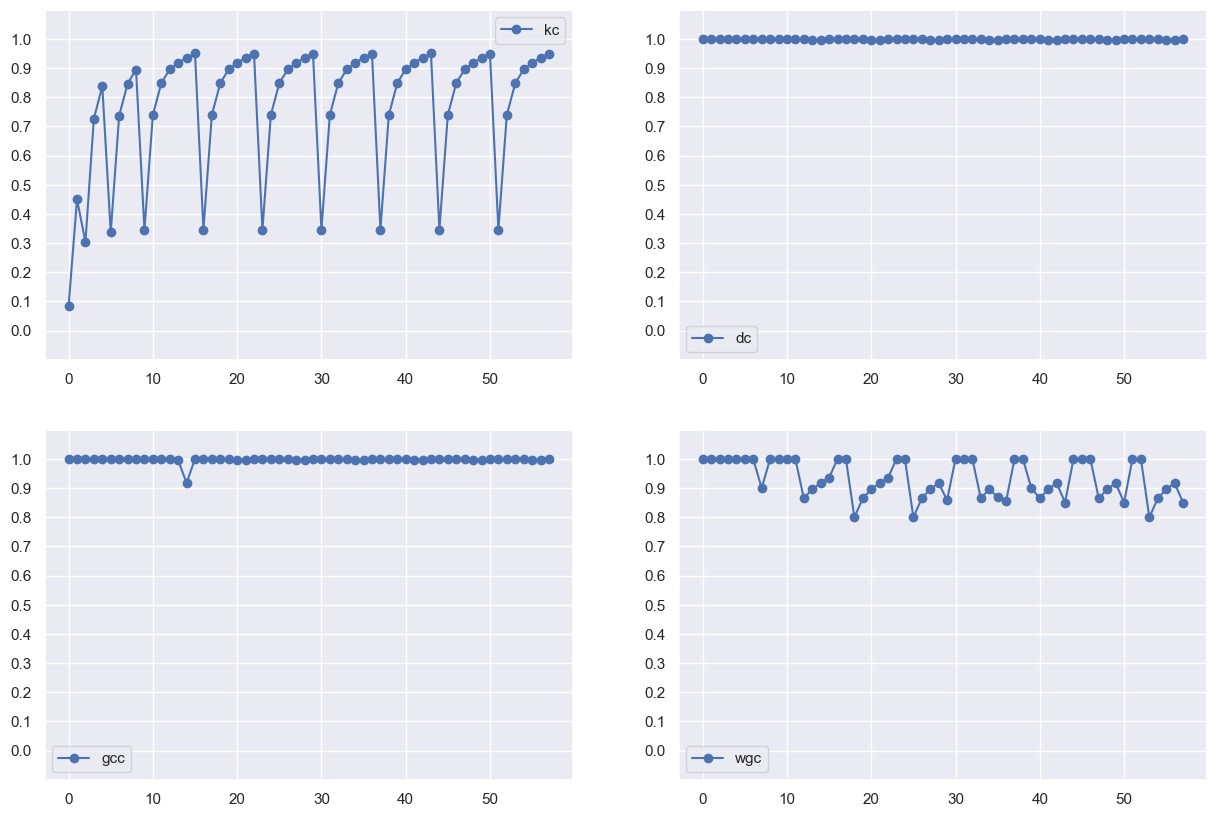

In [31]:
from seaborn import set_theme
set_theme()

plt.figure(figsize=(15,10))
# plt.subplots_adjust(hspace=0.33)
for method in method_dict.keys():
    plt.subplot(2,2,1+list(method_dict.keys()).index(method))
    plt.plot([plot_dict_median[(p,K,method)] for p,K in pK_comb], linestyle="-", marker="o", label=method)
    plt.legend()
    plt.ylim(-0.1,1.1)
    plt.yticks(np.linspace(0,1,11))
plt.show()

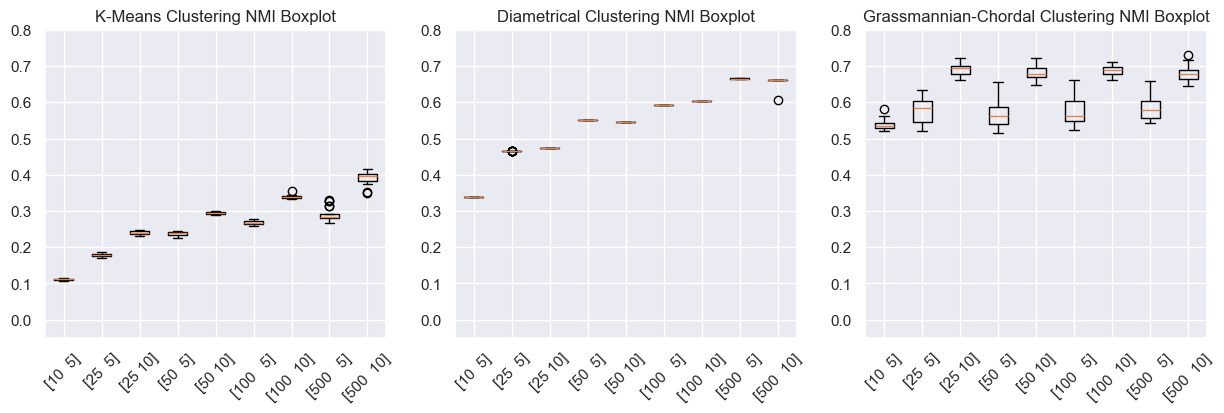

In [6]:
from clustering_helper import *

kc_data = single_clustering("kc", N=20, force=False)
dc_data = single_clustering("dc", N=20, force=False)
gcc_data = single_clustering("gcc", N=20, force=False)
ggc_data = single_clustering("ggc", N=20, force=False)
# wgc_data = single_clustering("wgc", N=1, force=False)
from seaborn import set_theme
set_theme()

plt.figure(figsize=(15,4))
plt.subplots_adjust(hspace=0.33)
for i,data in enumerate([kc_data, dc_data, gcc_data]):
    plt.subplot(1,3,1+i)
    nmi_dict = get_nmi_dict(data)
    nmi_vals = list(np.array(list(nmi_dict.values()))[[2,4,5,7,8,10,11,13,14]])
    nmi_keys = list(np.array(list(nmi_dict.keys()))[[2,4,5,7,8,10,11,13,14]])
    
    plt.boxplot(nmi_vals)
    plt.xticks(range(1, len(nmi_keys)+1), nmi_keys, rotation=45)
    plt.ylim(-.05, .8)
    plt.title(f'{["K-Means","Diametrical","Grassmannian-Chordal","Grassmannian-Geodesic"][i]} Clustering NMI Boxplot')
plt.show()

In [2]:
data_circle,p,K_true = generate_circle() # p=2, K=2

fake_cosine(data_circle, K)

NameError: name 'generate_circle' is not defined

(-1.2, 1.2)

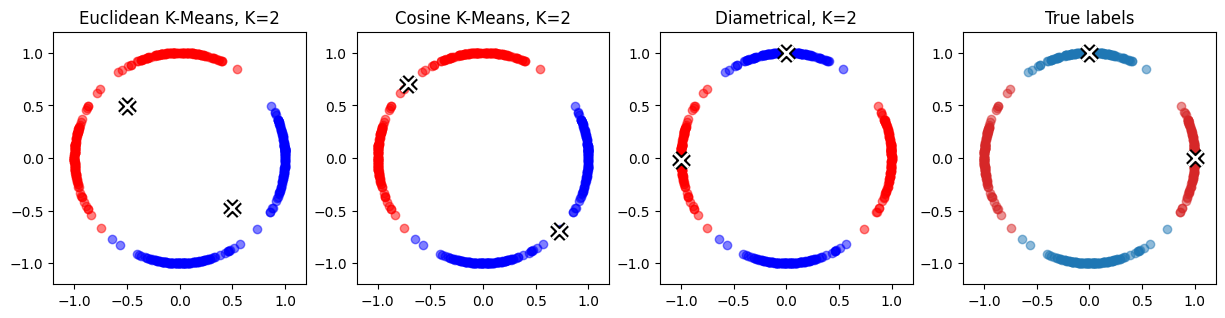

In [52]:
### FOR CREATING CIRCLE PLOT EXAMPLES ###


import numpy as np
normalize = lambda x: x / np.linalg.norm(x)

def generate_circle(N=500):
    clusters = [np.array(center) + np.random.randn(N//4, 2)*0.23 for center in [[1,0], [-1,0], [0,1], [0,-1]]]
    clusters = [normalize(c) for cluster in clusters for c in cluster]
    data_circle = np.vstack(clusters)
    return data_circle, 2,2, np.repeat(np.arange(2), N//2)


data_circle,p,K_true,true_labels = generate_circle() # p=2, K=2

def fake_cosine(data_circle, K, data_gr=False):
    centroids,labels,_ = kmeans_clustering(data_circle, K, data_gr=False)
    centroids = np.array([normalize(c) for c in centroids])
    return centroids,labels,_

K=2
plt.figure(figsize=(15,5))
for idx, clust_method in enumerate([kmeans_clustering, fake_cosine, diametrical_clustering]):
    centroids,labels,_ = clust_method(data_circle, K, data_gr=False)
    plt.subplot(1,4,idx+1)
    plt.title(f'{["Euclidean K-Means", "Cosine K-Means", "Diametrical"][idx]}, K={K}')
    colors = ['r', 'b', 'g', 'y']
    for k in range(K):
        data_k = data_circle[labels == k]
        plt.scatter(data_k[:, 0], data_k[:, 1], alpha=0.5, color=colors[k])

    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, linewidths=5)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='white', marker='x', s=100, linewidths=2)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)

plt.subplot(1,4,4)
plt.title('True labels')
plt.scatter(data_circle[true_labels==0, 0], data_circle[true_labels==0, 1], alpha=0.5, color='tab:red')
plt.scatter(data_circle[true_labels==1, 0], data_circle[true_labels==1, 1], alpha=0.5, color='tab:blue')

true_centroids = np.array([[1,0], [0,1]])
plt.scatter(true_centroids[:, 0], true_centroids[:, 1], color='black', marker='x', s=100, linewidths=5)
plt.scatter(true_centroids[:, 0], true_centroids[:, 1], color='white', marker='x', s=100, linewidths=2)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

In [ ]:
objt = []
i = 0
while i < 10:
    print(i)
    try:
        objt.append(weighted_grassmann_clustering(data_gr, data_eigvals, K))
        i += 1
    except ValueError as e:
        clear_output()
        if str(e) == "probabilities contain NaN":
            raise e
        continue

def save_clust(clust_dict, method="kc"):
    return pickle.dump(clust_dict, open(f"generated_data/continuous_clustering_{method}.pkl", "wb"))
def load_clust(method="kc"):
    return pickle.load(open(f"generated_data/continuous_clustering_{method}.pkl", "rb"))

loaded_clust = load_clust(method="wgc")
try: loaded_clust[p,K] += objt
except KeyError: loaded_clust[p,K] = objt
save_clust(loaded_clust, method="wgc")

9


In [ ]:
from NMI import *
labels = [i[2] for i in loaded_clust[p,K]]
true_labels = get_true_labels(K,N)
[print(calc_NMI(true_labels, labels[i])) for i in range(len(labels))];

0.2851981531356456
0.04087828987845038
0.04087828987845038
0.2851981531356456
0.36421193003278435
0.04087828987845038
0.32880085884128873
0.28057036702160004
0.04087828987845038
0.28057036702160004
0.3515844552223307
0.3507049188165694
1.0
0.3507049188165694
1.0
0.3507049188165694
0.3507049188165694
0.3507049188165694
0.3515844552223307
0.35114453757264835
0.401195830132556
1.0
0.401195830132556
1.0
1.0
0.401195830132556
0.401195830132556
0.40135504370181274
1.0
1.0


In [ ]:
from clustering_helper import *
from NMI import *

p,K= 25,5
for label in [i[1] for i in load_clust(method="kc")[p,K]]:
    # print(calc_NMI(get_true_labels(K,10_000), label))

0.17001126576007256
0.17560822811679316
0.1807094994300237
0.17190131581383375
0.18065942572190619
0.18366352669235872
0.18486373121133629
0.17475719329043798
0.1759631149298836
0.1840357361914772
0.17879895569358456
0.18672363674471779
0.1823234925728671
0.17586871291044912
0.17895277662505094
0.17042028185789396
0.18242054251562456
0.1786573388092707
0.18729151114020343
0.1733336535256683


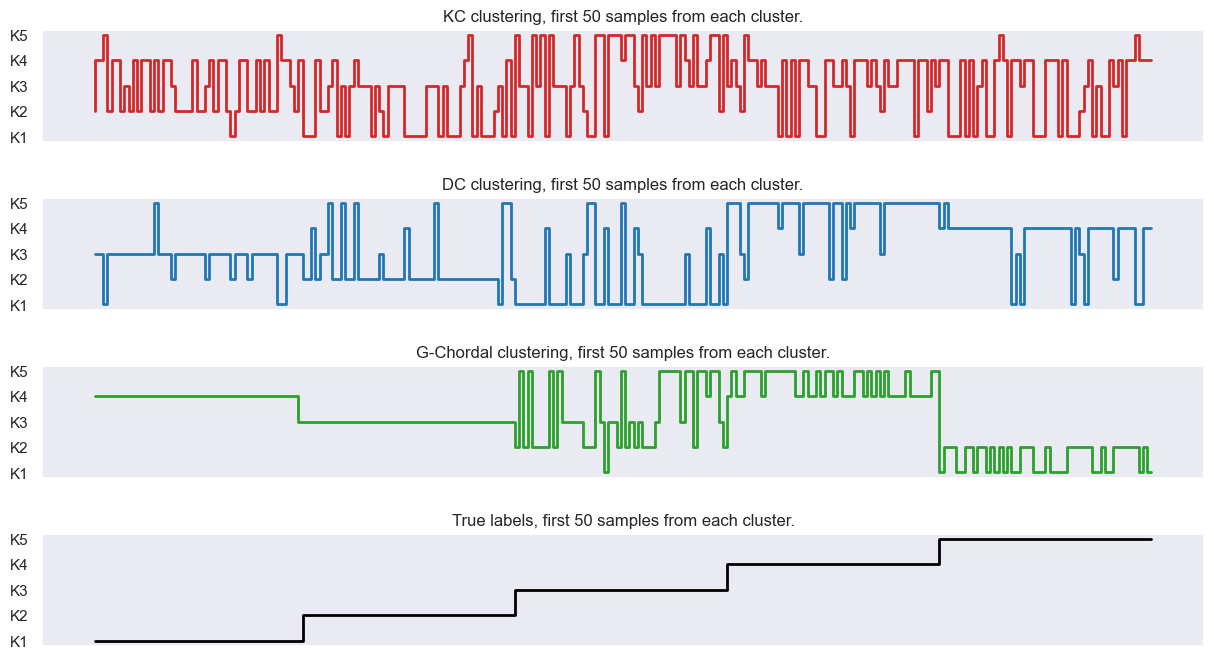

In [9]:
def sample_labels(labels, K, sample_points=50):
    idx_n = labels.shape[-1]//K
    return np.concatenate([labels[i*idx_n:i*idx_n+sample_points] for i in range(K)])

import seaborn as sns
sns.set_theme()

def plot_nmi_labels(labels_list, K, sample_points=50):
    plt.figure(figsize=(15,8))
    for i in range(len(labels_list)-1):
        plt.subplot(len(labels_list)-1+1,1,i+1)
        plt.subplots_adjust(hspace=0.5)
        plt.title(f'{["KC","DC","G-Chordal","G-Geodesic"][i]} clustering, first {sample_points} samples from each cluster.')
        samp_labels=sample_labels(labels_list[i], K, sample_points=sample_points)
        plt.step(range(len(samp_labels)), samp_labels, linewidth=2, color=["tab:red", "tab:blue", "tab:green", "tab:orange"][i])
        # plt.plot(samp_labels)
        plt.grid(axis='y')
        plt.yticks(range(K), [f"K{i+1}" for i in range(K)])
        plt.xticks([])
    plt.subplot(len(labels_list)-1+1,1,len(labels_list)-1+1)
    plt.title(f"True labels, first {sample_points} samples from each cluster.")
    samp_labels=sample_labels(get_true_labels(K), K)
    plt.step(range(len(samp_labels)), samp_labels, linewidth=2, color="black")
    plt.yticks(range(K), [f"K{i+1}" for i in range(K)])
    plt.xticks([])
    plt.grid(axis='y')
    plt.show()

p,K = 25,5
all_labels = [load_clust(method=mth)[p,K][0][1] for mth in ["kc", "dc", "gcc", "ggc"]]
plot_nmi_labels(all_labels, K)